# Cluster drawing to create samples from it
Previous attemps to learn on entire drawing was unsuccessfull, so I decided to move from new approach.
I.e. i will try to create a cluster of lines from the drawing that will be a learning sample x.
Than we will calculate some distance from cluster to dimensions on the drawing to attribute each dimension with the cluster. That attribution will be our Y.

In [1]:
# Start with basic example of unsupervised clustering with unknown number of clusters
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In [2]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [3]:
import pymongo
import pandas as pd
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline

import torch

# from processing import *

In [4]:
client = MongoClient('mongodb://10.0.4.26:27017')
db = client.geometry

fileids  = db.files.find({'Valid':True}).distinct('FileId')
print('files count', len(fileids))

# all the data will be too much for now, so we will take say 42 files:
fileids = fileids[:12]

query = {
    'ClassName':
    {
        '$in':[
            'AcDbLine',
            #'AcDbPolyline',
            'AcDbText',
            'AcDbRotatedDimension'
        ]
    },
    'FileId':{
        '$in':fileids
    }
}

data = pd.DataFrame(list(db.objects.find(query)))
print('data length', len(data))

files count 322
data length 20543


In [5]:
data

,_id,Color,Layer,LineWeight,Linetype,ObjectId,ClassName,Position,TextString,FileId,EndPoint,Length,StartPoint,DimLinePoint,DimensionStyleName,DimensionText,TextPosition,XLine1Point,XLine2Point
0,5fd0b427fe680417b0d7074d,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342192,AcDbText,"{'ClassName': 'Point3D', 'X': 7.69577632622433...",Pen Width HP Designjet 755 (mm),006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5fd0b427fe680417b0d7074e,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342256,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",6,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5fd0b427fe680417b0d7074f,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342832,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",7,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5fd0b427fe680417b0d70750,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342960,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",3,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5fd0b427fe680417b0d70751,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448343088,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",4,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20538,5fd0cce8f44995d7a5ae5e2c,red,STANDARD,LineWeight050,GETRENNT2_S6,2143359239072,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",1.714989,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",NaN,NaN,NaN,NaN,NaN,NaN
20539,5fd0cce8f44995d7a5ae5e2d,blue,STANDARD,LineWeight050,STRICHPUNKT2_S5,2143359239648,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",1.714989,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",NaN,NaN,NaN,NaN,NaN,NaN
20540,5fd0cce8f44995d7a5ae5e2e,202,STANDARD,LineWeight025,Continuous,2143359241312,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",1.714989,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",NaN,NaN,NaN,NaN,NaN,NaN
20541,5fd0cce8f44995d7a5ae5e2f,32,STANDARD,LineWeight050,VERDECKT2_S2,2143359237664,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",1.714989,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
from processing import Col2Numpy

groupped = data.groupby(['FileId'])
column_names = ['StartPoint', 'EndPoint', 'XLine1Point', 'XLine2Point']

# Whole point here is that we're keeping index from the original dataset in file_points

file_points = {} #dic[FileId]list_Of_Points
# all file ids
file_ids = list(groupped.groups.keys())
for file_id in file_ids:
    pnts = Col2Numpy(groupped.get_group(file_id), column_names)
    # print(pnts)
    file_points[file_id]=pnts

num_points = 0
for k in file_points:
    num_points += len(file_points[k])
print('Total number of points: ', num_points)

Total number of points:  35746


# Implement and check clustering algorithm

In [7]:
def Clusterize(x, eps = 0.2):
    '''
    The very basic clustering with unknown number of clusters
    https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
    eps=0.2 was set as default after a bit of playing with algorithm
    '''
    
    # algorithm='kd_tree'
    db = DBSCAN(eps=eps, min_samples=6, n_jobs=-1).fit(x1)
    labels = db.labels_
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    return labels, n_clusters, n_noise, db.core_sample_indices_

# Display clustering result

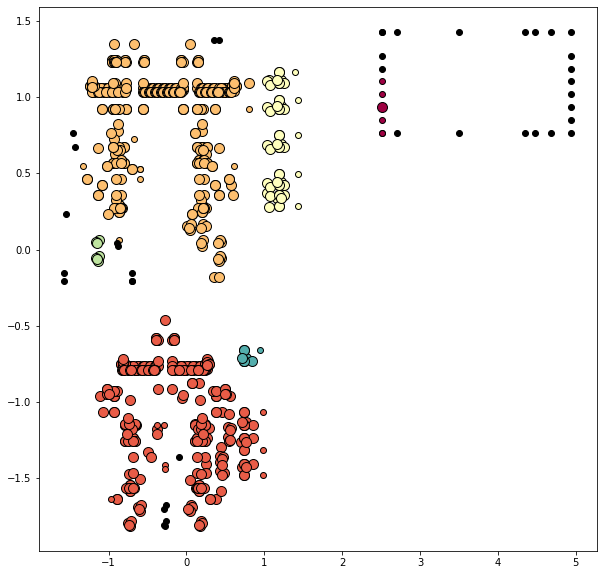

Eps 0.2
Total number of points:  790
Number of clusters:  6
Number of noise points:  40


In [8]:
from plot_graphics import draw_set

for file_id in file_points:
    x1 = file_points[file_id]
    
    # https://stackoverflow.com/questions/32270831/split-of-numpy-array-into-unequal-chunks
    x1,idx = np.split(x1,[3], axis = 1)
    
    n_pnts = x1.shape[0]
    
    if (n_pnts < 100):
        continue
    
    #for ep in np.arange(0.15, 0.25, 0.025):
    for ep in [0.2]:
        x1 = StandardScaler().fit_transform(x1)
        labels, n_clusters, n_noise, core_indices = Clusterize(x1, eps = ep)
        
        #if (n_noise / n_pnts < 0.9 and n_clusters > 1):
        if True:
            draw_set(x1, labels, core_indices)
            print ("Eps", ep)
            print("Total number of points: ", n_pnts)
            print("Number of clusters: ", n_clusters)
            print("Number of noise points: ", n_noise)
    break

In [9]:
# DBSCAN visually best eps for my data
best_eps = 0.2

df1 = pd.DataFrame(data)
df1['label'] = -1
for file_id in file_points:
    x1 = file_points[file_id]
    
    x1, data_indexes = np.split(x1,[3], axis = 1)
    data_indexes = data_indexes.astype('int')
    
    x1 = StandardScaler().fit_transform(x1)
    labels, n_clusters, n_noise, core_indices = Clusterize(x1, eps = best_eps)
    data_indexes['label'] = labels
    
    # https://stackoverflow.com/questions/22918212/fastest-way-to-drop-duplicated-index-in-a-pandas-dataframe
    # data_indexes = data_indexes.drop_duplicates('id')
    data_indexes = data_indexes.groupby(data_indexes.index).first()
    
    for i in range(len(data_indexes.index)):
        indx = data_indexes.index[i]
        # https://stackoverflow.com/questions/13021654/get-column-index-from-column-name-in-python-pandas
        df1.iloc[indx, df1.columns.get_loc('label')] = data_indexes.iloc[i, data_indexes.columns.get_loc('label')]
    
    #print(df.groupby(['FileId', 'label']).count())
    #df = df.join(data_indexes, on=['id'], how='left', rsuffix='_r')
    print(file_id)

006cb2dd-6f18-4203-8b70-fc865c08105a
006f290c-7280-491b-b7d7-971ed82de1a5
0100c16b-c7c9-4265-92b9-950bf5d2c9ec
013edfac-9865-4422-a5f2-3220d142116d
01ea3780-b297-4075-8a26-77461e995b7d
01f9cbe6-c14f-4dc0-817e-4d80380d4e26
02401882-a7cc-47ad-b8c2-c38eb9be323b
024be99c-0302-43b3-92b3-aa0aba5a376a
02580ab5-a831-4845-a46a-874a6fce6230
026c216c-8d4e-4b03-bca0-47e1286211f7
0323fe46-6856-4a65-9bd0-9dfe7805388a
03269695-2af6-41d1-ba41-fcf863b3f059


In [10]:
df = pd.DataFrame(df1)
df

,_id,Color,Layer,LineWeight,Linetype,ObjectId,ClassName,Position,TextString,FileId,EndPoint,Length,StartPoint,DimLinePoint,DimensionStyleName,DimensionText,TextPosition,XLine1Point,XLine2Point,label
0,5fd0b427fe680417b0d7074d,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342192,AcDbText,"{'ClassName': 'Point3D', 'X': 7.69577632622433...",Pen Width HP Designjet 755 (mm),006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,5fd0b427fe680417b0d7074e,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342256,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",6,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,5fd0b427fe680417b0d7074f,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342832,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",7,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,5fd0b427fe680417b0d70750,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448342960,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",3,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,5fd0b427fe680417b0d70751,cyan,PLOTTER,ByLayer,CONTINUOUS,2981448343088,AcDbText,"{'ClassName': 'Point3D', 'X': 8.73335230211607...",4,006cb2dd-6f18-4203-8b70-fc865c08105a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20538,5fd0cce8f44995d7a5ae5e2c,red,STANDARD,LineWeight050,GETRENNT2_S6,2143359239072,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",1.714989,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",NaN,NaN,NaN,NaN,NaN,NaN,-1
20539,5fd0cce8f44995d7a5ae5e2d,blue,STANDARD,LineWeight050,STRICHPUNKT2_S5,2143359239648,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",1.714989,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",NaN,NaN,NaN,NaN,NaN,NaN,-1
20540,5fd0cce8f44995d7a5ae5e2e,202,STANDARD,LineWeight025,Continuous,2143359241312,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",1.714989,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",NaN,NaN,NaN,NaN,NaN,NaN,-1
20541,5fd0cce8f44995d7a5ae5e2f,32,STANDARD,LineWeight050,VERDECKT2_S2,2143359237664,AcDbLine,NaN,NaN,03269695-2af6-41d1-ba41-fcf863b3f059,"{'ClassName': 'Point3D', 'X': 35.0591016204728...",1.714989,"{'ClassName': 'Point3D', 'X': 33.3441128263435...",NaN,NaN,NaN,NaN,NaN,NaN,-1


In [11]:
from processing import expand_columns
df = expand_columns(df, column_names)
x_columns = ['StartPoint.X', 'StartPoint.Y', 'StartPoint.Z',
             'EndPoint.X', 'EndPoint.Y', 'EndPoint.Z']
y_columns = ['XLine1Point.X', 'XLine1Point.Y','XLine1Point.Z', 
    'XLine2Point.X', 'XLine2Point.Y', 'XLine2Point.Z']
join_index = ['FileId','label']
groupping_columns = [ 'ClassName', 'FileId','label']
dataset_columns = x_columns + y_columns + groupping_columns 

df = df[dataset_columns]

In [12]:
df.to_pickle('test_dataset_cluster_labeled.pickle')

# Test classes to work with data

In [13]:
from torch.utils.data import Dataset, SubsetRandomSampler
from dataset import EntityDataset


In [14]:
d = pd.read_pickle('test_dataset_cluster_labeled.pickle')

for x,y in EntityDataset(d)[:10]:
    print(x.shape,y)

torch.Size([6, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([159, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([182, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([26, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([2, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([4, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([89, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([89, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([89, 6]) tensor([[0., 0., 0., 0., 0., 0.]])
torch.Size([89, 6]) tensor([[0., 0., 0., 0., 0., 0.]])


In [15]:
from dataset import DwgDataset

In [16]:
def test_dataset():
    dataset = DwgDataset('test_dataset_cluster_labeled.pickle', batch_size = 4)

    for (x, y) in iter(dataset.train_loader):
        for i in range(len(x)):
            print(x[i].shape, y[i])
        break
        
test_dataset()

torch.Size([21, 6]) tensor([0., 0., 0., 0., 0., 0.])
torch.Size([58, 6]) tensor([0., 0., 0., 0., 0., 0.])
torch.Size([12, 6]) tensor([0., 0., 0., 0., 0., 0.])
torch.Size([25, 6]) tensor([0., 0., 0., 0., 0., 0.])
